# 2.1 Tidy data

In this notebook, we take a closer look at the BL books dataset and tidy it up.

In [1]:
# imports

import pandas as pd
import json, os, codecs
from collections import defaultdict, OrderedDict
import seaborn as sns

## Import the dataset
Let us import the sample dataset in memory, as it is, without transformations. We rely on some Python libraries to do so.

In [ ]:
root_folder = "../data/bl_books/sample/"

# metadata: stored in a single JSON file
filename = "book_data_sample.json"
metadata = json.load(codecs.open(os.path.join(root_folder,filename), encoding="utf8"))

# fulltexts: stored in several JSON files, one per book
foldername = "full_texts"
texts = defaultdict(list)
for root, dirs, files in os.walk(os.path.join(root_folder,foldername)):
    for f in files:
        if ".json" in f:
            t = json.load(codecs.open(os.path.join(root,f), encoding="utf8"))
            texts[f] = t

# enriched metadata: stored in a single CSV file
filename = "extra_metadata_sample.csv"
df_extra = pd.read_csv(os.path.join(root_folder,filename), delimiter=";")
df_extra = df_extra.rename(str.lower, axis='columns') # rename columns to lower case

## Take a look
Let's take a look to the dataset

In [3]:
# there are 452 books in the sample

print(len(metadata))

452


In [4]:
# each one contains the following catalog metadata

metadata[0]

{'datefield': '1841',
 'shelfmarks': ['British Library HMNTS 11601.ddd.2.'],
 'publisher': 'Privately printed',
 'title': ["The Poetical Aviary, with a bird's-eye view of the English poets. [The preface signed: A. A.] Ms. notes"],
 'edition': '',
 'flickr_url_to_book_images': 'http://www.flickr.com/photos/britishlibrary/tags/sysnum000000196',
 'place': 'Calcutta',
 'issuance': 'monographic',
 'authors': {'creator': ['A. A.']},
 'date': '1841',
 'pdf': {'1': 'lsidyv35c55757'},
 'identifier': '000000196',
 'corporate': {},
 'fulltext_filename': 'sample/full_texts/000000196_01_text.json'}

**Questions** on 'metadata':

* Can you identify some messy aspects of this dataset representation?
* Take a look at the 'shelfmarks' or 'title' fields: what is the problem here?
* Do the same for the 'authors' and 'pdf' fields: what is the problem?
* Look at the datefield of the *third* item in this list: is there a problem?

In [5]:
# let's check we have the same amount of books with a text file

print(len(texts))

452


*Note: we have selected for the sample just the first volume/pdf for every book.*

In [5]:
len(texts['000000196_01_text.json'])

164

In [4]:
# each text comes as a list of lists: one per page, as follows [page number, text]

texts['000000196_01_text.json'][:9]

[[1, ''],
 [2, ''],
 [3, ''],
 [4, ''],
 [5, ''],
 [6, ''],
 [7,
  "THE POETICAL AVIARY, WITH A B I R D'S-E YE VIEW OF THE ENGLISH POETS. (NOT PUBLISHED.) CALCUTTA: PRINTED AT THE BAPTIST MISSION PRESS, CIRCULAR ROAD. 1841."],
 [8, ''],
 [9,
  'POETICAL AVIARY. PART THE FIRST. BIRDS WITHOUT ALLUSION TO THEIR NOTES. One of the curious political medals that were struck in the reign of Charles II. represents, on one side, Titus Oates with two faces. On the reverse are the heads of the king and four of his principal ministers, with this motto round the border, " Birds of a feather flock together." This, as well as various other proverbs derived from birds, haee been introduced into poetry. Thus Anstey — And \'twas pretty to see how like birds of a feather The people of quality flocked all together, All pressing, addressing, caressing, and fond, Just the same as those animals do in a pond. Under the sign of an inn representing a man with a bird in his hand, and two birds in a bush I have se

In [5]:
df_extra

,aleph system no.,country code,language code (008),language code (041),ddc,personal author,corporate author,title,edition,imprint,series,subjects,other personal authors,other corporate authors,dom id,type,genre,first_pdf
0,14805618,|||,eng,NaN,NaN,"BONNEY, Thomas George.",NaN,The Alpine Regions of Switzerland and the neig...,NaN,"Cambridge : Deighton, Bell & Co., 1868.",NaN,NaN,"WHYMPER, Edward.",NaN,lsidyv3becb649,story,Prose,lsidyv3becb649
1,14939494,|||,eng,NaN,NaN,"FREEMAN, Edward Augustus.",NaN,[The History of the Norman Conquest of England...,"Third edition, revised. vol. 1, 2.","Oxford, 1877.",NaN,NaN,NaN,NaN,lsidyv386a29a7 -- lsidyv386a4a87,story,Prose,lsidyv386a29a7
2,14828093,|||,eng,NaN,NaN,"REDFERN, Francis.",NaN,History of the Town of Uttoxeter; with notices...,NaN,"London, 1865.",NaN,NaN,NaN,NaN,lsidyv3c4d30a3,story,Prose,lsidyv3c4d30a3
3,14880318,|||,eng,NaN,NaN,"SIMONDE DE SISMONDI, Jean Charles Léonard.",NaN,The History of the French ... Translated by W....,NaN,"London, 1849, 50.",NaN,NaN,"BELLINGHAM, William, of Lincoln's Inn.",NaN,lsidyv2af98846,story,Prose,lsidyv2af98846
4,14872367,|||,eng,NaN,NaN,"MIKHAILOVSKY-DANILEVSKY, Aleksandr Ivanovich, ...",NaN,History of the Campaign in France in the year ...,NaN,"London, 1839.",NaN,NaN,NaN,NaN,lsidyv370ba897,story,Prose,lsidyv370ba897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,15743151,enk,eng,NaN,NaN,NaN,NaN,"The dramatic works of Wycherley, Congreve, Van...",A new ed.,"London : Edward Moxon, 1851.",NaN,NaN,"Wycherley, William, 1640-1716. -- Congreve, Wi...",NaN,lsidyv349212f1,play,Drama,lsidyv349212f1
476,14814805,|||,eng,NaN,NaN,NaN,NaN,Looking Glass for my Poli-comedie actors in Eu...,NaN,"Bombay, 1891.",NaN,NaN,NaN,NaN,lsidyv3ce84653,comedy,Drama,lsidyv3ce84653
477,14846809,|||,eng,NaN,NaN,"ARTERTON, A.",NaN,"Thespis and Melpomene. A lyrical drama, in fou...",NaN,"London : London Literary Society, [1885.].",NaN,NaN,NaN,NaN,lsidyv35cf487e,play,Drama,lsidyv35cf487e
478,14847467,|||,eng,NaN,NaN,"JENNER, Katharine Amabel.",NaN,Half-hour Plays. Rumpelstilskin and other play...,NaN,"London : W. Smith & Innes, 1889.",NaN,NaN,NaN,NaN,lsidyv35e8df0c,play,Drama,lsidyv35e8df0c


In [6]:
# the extra metadata can be already used as a data frame

df_extra[df_extra["first_pdf"] == "lsidyv35c55757"]
# we perform here a selection of rows which abide to a given condition. We'll see more of this later on.

,aleph system no.,country code,language code (008),language code (041),ddc,personal author,corporate author,title,edition,imprint,series,subjects,other personal authors,other corporate authors,dom id,type,genre,first_pdf
234,14846757,|||,eng,NaN,NaN,A. A.,NaN,"The Poetical Aviary, with a bird's-eye view of...",NaN,"Calcutta : Privately printed, 1841.",NaN,NaN,NaN,NaN,lsidyv35c55757,poet,Poetry,lsidyv35c55757


**Question**: explore this data frame and find examples of messy aspects.

In [17]:
metadata[0]

{'datefield': '1841',
 'shelfmarks': ['British Library HMNTS 11601.ddd.2.'],
 'publisher': 'Privately printed',
 'title': ["The Poetical Aviary, with a bird's-eye view of the English poets. [The preface signed: A. A.] Ms. notes"],
 'edition': '',
 'flickr_url_to_book_images': 'http://www.flickr.com/photos/britishlibrary/tags/sysnum000000196',
 'place': 'Calcutta',
 'issuance': 'monographic',
 'authors': {'creator': ['A. A.']},
 'date': '1841',
 'pdf': {'1': 'lsidyv35c55757'},
 'identifier': '000000196',
 'corporate': {},
 'fulltext_filename': 'sample/full_texts/000000196_01_text.json'}

## Create dataframes from legacy data

The extra bibliographic metadata were already loaded into the `df_extra` dataframe, remember?

However, book metadata and information about fulltexts are not yet stored in dataframes, so let's do that.

In [6]:
# you've probably executed already this cell at the very beginning of the notebook
# but for the sake of readability we copy it here as well, so that it's closer to the 
# code that transforms it into a dataframe

root_folder = "../data/bl_books/sample/"

# metadata: stored in a single JSON file
filename = "book_data_sample.json"
metadata = json.load(codecs.open(os.path.join(root_folder,filename), encoding="utf8"))

`metadata` is a list of dictionaries as the `json.load()` function reads the content of file `../data/bl_books/sample/book_data_sample.json` into a list of dictionaries.

As a reminder, this is what one of these dictionaries looks like (here we are peeking at the first element of the list):

In [7]:
metadata[0]

{'datefield': '1841',
 'shelfmarks': ['British Library HMNTS 11601.ddd.2.'],
 'publisher': 'Privately printed',
 'title': ["The Poetical Aviary, with a bird's-eye view of the English poets. [The preface signed: A. A.] Ms. notes"],
 'edition': '',
 'flickr_url_to_book_images': 'http://www.flickr.com/photos/britishlibrary/tags/sysnum000000196',
 'place': 'Calcutta',
 'issuance': 'monographic',
 'authors': {'creator': ['A. A.']},
 'date': '1841',
 'pdf': {'1': 'lsidyv35c55757'},
 'identifier': '000000196',
 'corporate': {},
 'fulltext_filename': 'sample/full_texts/000000196_01_text.json'}

Let's start by turning the content of `metadata` (list of dictionaries) into a dataframe.
In order to do so, we create a dictionary of lists:
- each key in the dictionary corresponds to a dataframe variable
- each key has as a value the list of observations of that specific variable

In the process, we drop some variables that we don't need at this stage (we simply ignore them and don't add them to the resulting dataframe).

In [8]:
# let's declare the empty lists where we will store the values
# keep in mind that each of these lists will become a column (series) of the resulting dataframe 
datefield = list() # '1841'
publisher = list() # 'Privately printed',
title = list() # ["The Poetical Aviary, with a bird's-eye view of the English poets. [The preface signed: A. A.] Ms. notes"]
edition = list() # ''
place = list() # 'Calcutta'
issuance = list() # 'monographic'
authors = list() # {'creator': ['A. A.']}
first_pdf = list() # {'1': 'lsidyv35c55757'}
number_volumes = list()
identifier = list() # '000000196'
fulltext_filename = list() # 'sample/full_texts/000000196_01_text.json'

# now we can iterate through our list of dictionaries
for book in metadata:
    if book["date"]:
        # we keep only the first four digits of `book["date"]`
        # in order to filter out years in brackets
        # and we cast this value to an integer
        datefield.append(int(book["date"][:4]))
    else:
        datefield.append(None)
    publisher.append(book["publisher"])
    
    # book["title"] is a list, so we keep only the first title
    title.append(book["title"][0])
    edition.append(book["edition"])
    place.append(book["place"])
    issuance.append(book["issuance"])

    # book["authors"] contained a dictionary
    # we flatten this dictionary into a list, which later
    # we will spinto into a dedicated dataframe
    if "creator" in book["authors"].keys():
        authors.append(book["authors"]["creator"]) # this is a list!
    else:
        authors.append([''])
    first_pdf.append(book["pdf"]["1"])

    # although we keep the fulltext of only the first volume
    # we want to store the number of volumes for a given book (for later analysis)
    number_volumes.append(len(book["pdf"]))
    identifier.append(book["identifier"])
    fulltext_filename.append(book["fulltext_filename"].split("/")[-1])

In [12]:
# we combine all the previously created lists into a single dictionary of lists
# which we pass directly to `pd.DataFrame.from_dict()`
input_dict = {
        "datefield": datefield,
        "publisher": publisher,
        "title": title,
        "edition": edition,
        "place": place,
        "issuance": issuance,
        "authors": authors,
        "first_pdf": first_pdf,
        "number_volumes": number_volumes,
        "identifier": identifier,
        "fulltext_filename": fulltext_filename
    }

df_meta = pd.DataFrame.from_dict(input_dict)

Before we create the dataframe, let's make sure that all the lists we just created have the same number of values = (observations):

In [9]:
assert len(datefield) == len(publisher) == len(title) == len(edition) == len(place) == len(issuance) == len(authors) == len(first_pdf) == len(number_volumes) == len(identifier) == len(fulltext_filename)

Let's now create a dataframe containing the fulltexts for the books in our dataset.

In [20]:
# fulltexts: stored in several JSON files, one per book
foldername = "full_texts"
texts = defaultdict(list)
for root, dirs, files in os.walk(os.path.join(root_folder,foldername)):
    for f in files:
        if ".json" in f:
            t = json.load(codecs.open(os.path.join(root,f), encoding="utf8"))
            texts[f] = t

In [30]:
# as a reminder of what the `texts` variable contains: it's
# a dictionary where keys are filenames and values are lists of [page_number, fulltext]
one_filename = list(texts.keys())[0]
texts[one_filename][:11]

[[1, ''],
 [2, ''],
 [3, ''],
 [4, ''],
 [5, ''],
 [6, ''],
 [7, ''],
 [8, ''],
 [9, ''],
 [10, '\' -■" \' LiLitr-- )Wm&,'],
 [11,
  'HISTORY OF THE TOWN OF GROTON, INCLUDING PEPPERELL AND SHIRLEY, FROM THE FIRST GRANT OF GROTON PLANTATION IN 1655. WITH APPENDICES, CONTAINING FAMILY REGISTERS, TOWN AND STATE OFFICERS, POPULATION, AND OTHER STATISTICS. BY CALEB BUTLER. "Pleraque eorum quæ referam parva forsitan et levia memoratu videri, non nescius sum." — Tacitus. " Small things, in the beginning of natural or politic bodies, are as remarkable as greater, in bodies full grown." — Qov. Dudley\'s Letter to Countess of Lincoln. BOSTON : PRESS OF T. R. MARVIN, No. 24 Congress Street. 1848.']]

In [31]:
# texts
how_many_pages = 50 # we reduce the amount of text to the first n pages, to make it faster to play with it
fulltext_filename = list()
fulltext = list()
for f,t in texts.items():
    fulltext_filename.append(f)

    # we concatenate the first 50 pages into one string per book/document
    text = " ".join([line[1] for line in t][:how_many_pages])
    fulltext.append(text)

df_texts = pd.DataFrame.from_dict({
    "fulltext_filename": fulltext_filename,
    "fulltext": fulltext}
)

In [32]:
df_texts.head()

,fulltext_filename,fulltext
0,000551646_01_text.json,"' -■"" ' LiLitr-- )Wm&, HISTORY OF THE..."
1,002674278_01_text.json,The Great Revolution of 1840. REMINISC...
2,001975731_01_text.json,THE REAR-GUARD OF THE REVOLUTION. BY E...
3,000570834_01_text.json,'Tis Well it's no Worfe: A COMEDY. As it is ...
4,001831273_01_text.json,OFFICIAL CORRESPONDENCE WITH THE DEPARTMEN...


## A second look
Let's check data types and typical values to be sure of what we have.

In [18]:
df_meta.dtypes

datefield            float64
publisher             object
title                 object
edition               object
place                 object
issuance              object
authors               object
first_pdf             object
number_volumes         int64
identifier            object
fulltext_filename     object
dtype: object

<AxesSubplot:>

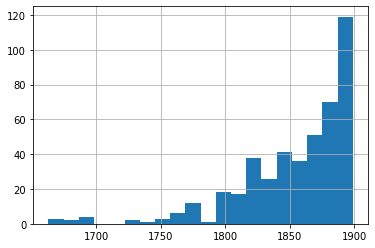

In [19]:
df_meta["datefield"].hist(bins=20)

<AxesSubplot:>

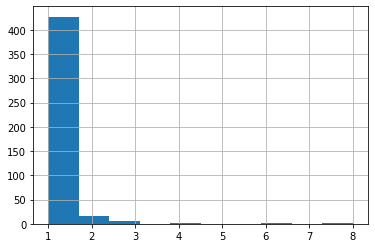

In [20]:
df_meta["number_volumes"].hist()

In [21]:
variable = "place"
df_meta[variable].value_counts()[:11]

London          243
New York         23
Dublin           10
Philadelphia     10
Edinburgh         9
enk               8
Leeds             8
Cambridge         6
Boston            6
                  5
Oxford            5
Name: place, dtype: int64

In [22]:
df_meta[variable].value_counts()[-10:]

Bangor, Ma           1
Bayonne              1
Newcastle            1
Framlingham          1
Nashua               1
J. Wiseheart         1
Springfield, Mass    1
New Haven            1
Cirencester          1
Privately printed    1
Name: place, dtype: int64

In [23]:
df_extra["genre"].value_counts()

Prose     120
Poetry    120
Music     120
Drama     120
Name: genre, dtype: int64

In [24]:
df_extra["type"].value_counts()

story         106
opera          79
play           64
ode            53
poet           37
song           36
tragedy        32
comedy         18
verse          10
lines           9
recitation      6
romance         6
elegy           6
melody          3
tale            3
novel           3
lyric           2
hymn            2
satire          2
rhyme           2
ballad          1
Name: type, dtype: int64

**Questions**:
    
* 'place' seems like a reasonably uniform variable. Try with 'edition' instead, and think about how that might be more problematic.
* While the 'genre' variable is uniform in representation, the 'type' variable is not. Can you find out what are the most well-represented types for each genre category? How might this influence our use of 'type' for analysis?

## UML modelling
From an Entity-Relationship model to a relational model (tidy data).

UML: Unified Modelling Language. A visual design language to go about modelling systems, including data. https://en.wikipedia.org/wiki/Unified_Modeling_Language

In [18]:
df_meta.head(1)

,datefield,publisher,title,edition,place,issuance,authors,first_pdf,number_volumes,identifier,fulltext_filename
0,1841.0,Privately printed,"The Poetical Aviary, with a bird's-eye view of...",,Calcutta,monographic,[A. A.],lsidyv35c55757,1,000000196,000000196_01_text.json


In [25]:
df_texts

,fulltext_filename,fulltext
0,000551646_01_text.json,"' -■"" ' LiLitr-- )Wm&, HISTORY OF THE..."
1,002674278_01_text.json,The Great Revolution of 1840. REMINISC...
2,001975731_01_text.json,THE REAR-GUARD OF THE REVOLUTION. BY E...
3,000570834_01_text.json,'Tis Well it's no Worfe: A COMEDY. As it is ...
4,001831273_01_text.json,OFFICIAL CORRESPONDENCE WITH THE DEPARTMEN...
...,...,...
448,003405646_01_text.json,"M/MEA & LAYCOCK Pflf^r^/iS,LŒ/)S. l^eabon, ..."
449,003865691_01_text.json,"THE HISTORY OF A LUMP OF IRON, <d|rom fit*..."
450,000387896_01_text.json,THE HISTORY OF SALT; WITH OBSERVATIONS ON ...
451,001845847_01_text.json,Xeisure IDour XiPrics C. W. JAMES LEISURE H...


In [19]:
df_texts[df_texts["fulltext_filename"] == '000000196_01_text.json']

,fulltext_filename,fulltext
150,000000196_01_text.json,"THE POETICAL AVIARY, WITH A B I R D'S-E ..."


In [20]:
df_extra[df_extra["first_pdf"] == "lsidyv35c55757"]

,aleph system no.,country code,language code (008),language code (041),ddc,personal author,corporate author,title,edition,imprint,series,subjects,other personal authors,other corporate authors,dom id,type,genre,first_pdf
234,14846757,|||,eng,NaN,NaN,A. A.,NaN,"The Poetical Aviary, with a bird's-eye view of...",NaN,"Calcutta : Privately printed, 1841.",NaN,NaN,NaN,NaN,lsidyv35c55757,poet,Poetry,lsidyv35c55757


**Now we switch to the blackboard and model!**

## Tidy dataset: relational-model

* Full view (for your curiosity): https://dbdiagram.io/d/5d06a4adfff7633dfc8e3a42
* Reduced view (we here use this one): https://dbdiagram.io/d/5d06a5d0fff7633dfc8e3a47

In [26]:
# first, join the extra metadata genre column to the metadata data frame. More details on joins in class 3.1.

df_extra_genre = df_extra[["type","genre","first_pdf"]]
df_book = df_meta.join(df_extra_genre.set_index('first_pdf'), on='first_pdf')

In [27]:
df_book.head(1)

,datefield,publisher,title,edition,place,issuance,authors,first_pdf,number_volumes,identifier,fulltext_filename,type,genre
0,1841.0,Privately printed,"The Poetical Aviary, with a bird's-eye view of...",,Calcutta,monographic,[A. A.],lsidyv35c55757,1,000000196,000000196_01_text.json,poet,Poetry


In [28]:
df_texts

,fulltext_filename,fulltext
0,000551646_01_text.json,"' -■"" ' LiLitr-- )Wm&, HISTORY OF THE..."
1,002674278_01_text.json,The Great Revolution of 1840. REMINISC...
2,001975731_01_text.json,THE REAR-GUARD OF THE REVOLUTION. BY E...
3,000570834_01_text.json,'Tis Well it's no Worfe: A COMEDY. As it is ...
4,001831273_01_text.json,OFFICIAL CORRESPONDENCE WITH THE DEPARTMEN...
...,...,...
448,003405646_01_text.json,"M/MEA & LAYCOCK Pflf^r^/iS,LŒ/)S. l^eabon, ..."
449,003865691_01_text.json,"THE HISTORY OF A LUMP OF IRON, <d|rom fit*..."
450,000387896_01_text.json,THE HISTORY OF SALT; WITH OBSERVATIONS ON ...
451,001845847_01_text.json,Xeisure IDour XiPrics C. W. JAMES LEISURE H...


In [21]:
df_book[["identifier","fulltext_filename"]].set_index('fulltext_filename')

,identifier
fulltext_filename,
000000196_01_text.json,000000196
000004047_01_text.json,000004047
000005382_01_text.json,000005382
000014627_01_text.json,000014627
000017057_01_text.json,000017057
...,...
003988464_01_text.json,003988464
003988508_01_text.json,003988508
003999073_01_text.json,003999073


In [29]:
# second, add the book_id to the book_text dataframe

df_book_text = df_texts.join(df_book[["identifier","fulltext_filename"]].set_index('fulltext_filename'), on='fulltext_filename')
df_book_text = df_book_text.rename(columns={"identifier":"book_id"})
df_book_text.head(3)

,fulltext_filename,fulltext,book_id
0,000551646_01_text.json,"' -■"" ' LiLitr-- )Wm&, HISTORY OF THE...",000551646
1,002674278_01_text.json,The Great Revolution of 1840. REMINISC...,002674278
2,001975731_01_text.json,THE REAR-GUARD OF THE REVOLUTION. BY E...,001975731


In [30]:
# third, pull our author information and create the author table and the author-book table

author_id = 0 # this is a counter which provides for a distinct identifier to every author
author_dict = OrderedDict()
author_book_table = {"book_id":list(),"author_id":list()}
for book_id, authors in df_book[["identifier","authors"]].values:
    for author in authors:
        if author not in author_dict.keys():
            author_dict[author] = author_id
            author_id += 1
        author_book_table["book_id"].append(book_id)
        author_book_table["author_id"].append(author_dict[author])
        
df_author_book = pd.DataFrame.from_dict(author_book_table)
df_author = pd.DataFrame.from_dict({"name":[v for v in author_dict.keys()],
                                   "id":[k for k in author_dict.values()]})
df_author.set_index("id", inplace=True)

In [31]:
df_author.head(3)

,name
id,
0,A. A.
1,"Abbott, Evelyn"
2,"A'BECKETT, Gilbert Abbott."


In [26]:
df_author_book.head(3)

,book_id,author_id
0,000000196,0
1,000004047,1
2,000005382,2


In [32]:
# drop authors from df_books
df_book.drop(columns=["authors"], inplace=True)

*Note: you don't need to do this: these dataframes are already there!*

In [33]:
# let's now save our data frames for future use
root_folder = "../data/bl_books/sample_tidy/"
df_book.to_csv(os.path.join(root_folder,"df_book.csv"), index=False)
df_author.to_csv(os.path.join(root_folder,"df_author.csv"), index=False)
df_author_book.to_csv(os.path.join(root_folder,"df_author_book.csv"), index=False)
df_book_text.to_csv(os.path.join(root_folder,"df_book_text.csv"), index=False)

## A last look at the tidy dataset

**Questions**:
* how many authors are there? Are there books with more than one author? And authors who published more than one book?
* How many books per genre do we have?
* What is the typical year of publication of our books?

## SQL and relational databases

Our tidy dataset is structured now as a relational database. 

SQL (Structured Query Language) is the general language to query such databases. https://en.wikipedia.org/wiki/SQL

MySQL and Postgresql are common implementation of relational databases.

To demonstrate how to load data from an SQL DB into a pandas dataframe, we create an instance of an SQLite DB (which lives in the memory of your computer and it's not persisted to disk) and load the datafrane we just created into it.

In [50]:
from sqlalchemy import create_engine
from sqlalchemy.types import Integer

# this is our SQLite DB
engine = create_engine('sqlite://', echo=False)

In [51]:
# we load the book dataframe we just created
root_folder = "../data/bl_books/sample_tidy/"
df_book = pd.read_csv(os.path.join(root_folder,"df_book.csv"))

In [52]:
# we now create an SQL table containing rows from `df_book`
# the new table is called `books`
df_book.to_sql('books', con=engine, index=False, dtype={"datefield": Integer()})

452

In [53]:
# we can execute SQL queries on the table we just created
sql_query = "SELECT * FROM books LIMIT 5"
engine.execute(sql_query).fetchall()

[(1841, 'Privately printed', "The Poetical Aviary, with a bird's-eye view of the English poets. [The preface signed: A. A.] Ms. notes", None, 'Calcutta', 'monographic', 'lsidyv35c55757', 1, 196, '000000196_01_text.json', 'poet', 'Poetry'),
 (1888, 'Rivingtons', 'A History of Greece. Part I. From the earliest times to the Ionian Revolt', None, 'London', 'monographic', 'lsidyv376da437', 1, 4047, '000004047_01_text.json', 'story', 'Prose'),
 (1847, 'Punch Office', 'The Comic History of England ... With ... coloured etchings, and ... woodcuts, by John Leech', None, 'London', 'monographic', 'lsidyv38b27a31', 1, 5382, '000005382_01_text.json', 'story', 'Prose'),
 (1892, 'Eden, Remington & Co.', "The Cruise of “The Tomahawk”: the story of a summer's holiday in prose and rhyme. By Mrs. R. S. de C. Laffan ... assisted by “Stroke” and “Bow.”", None, 'London', 'monographic', 'lsidyv3c4a946a', 1, 14627, '000014627_01_text.json', 'rhyme', 'Poetry'),
 (1863, 'Virtue Bros. & Co.', 'Scenes from the Dr

In [54]:
# and we can also create a dataframe from a DB table
# by using pandas' `read_sql_query()` function
sql_query = "SELECT * FROM books"
df_books_fromDB = pd.read_sql_query(sql_query, engine)

In [55]:
df_books_fromDB.head(5)

,datefield,publisher,title,edition,place,issuance,first_pdf,number_volumes,identifier,fulltext_filename,type,genre
0,1841.0,Privately printed,"The Poetical Aviary, with a bird's-eye view of...",None,Calcutta,monographic,lsidyv35c55757,1,196,000000196_01_text.json,poet,Poetry
1,1888.0,Rivingtons,A History of Greece. Part I. From the earliest...,None,London,monographic,lsidyv376da437,1,4047,000004047_01_text.json,story,Prose
2,1847.0,Punch Office,The Comic History of England ... With ... colo...,None,London,monographic,lsidyv38b27a31,1,5382,000005382_01_text.json,story,Prose
3,1892.0,"Eden, Remington & Co.",The Cruise of “The Tomahawk”: the story of a s...,None,London,monographic,lsidyv3c4a946a,1,14627,000014627_01_text.json,rhyme,Poetry
4,1863.0,Virtue Bros. & Co.,Scenes from the Drama of European History,None,London,monographic,lsidyv32c34c22,1,17057,000017057_01_text.json,play,Drama
